In [1]:
# Import necessary libraries and methods
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import optuna
from optuna.integration import OptunaSearchCV
import matplotlib.pyplot as plt
import textwrap
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.preprocessing import label_binarize
from itertools import cycle

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load training scaled datasets
data_path = "../data/preprocessed/preprocessed_data_20250720_131842"

X_train = pd.read_csv(os.path.join(data_path, 'X_train_scaled.csv'))
y_train = pd.read_csv(os.path.join(data_path, 'y_train_scaled.csv'))

# Load test datasets
X_test = pd.read_csv(os.path.join(data_path, 'X_test_scaled.csv'))
y_test = pd.read_csv(os.path.join(data_path, 'y_test_scaled.csv'))

In [3]:
# Flatten y_train and y_test to be (n_samples, )
y_train_reshaped = np.ravel(y_train) 
y_test_reshaped = np.ravel(y_test)
print(y_train_reshaped.shape)
print(y_test_reshaped.shape)

(1688,)
(423,)


### I) Experiment with baseline model using Support Vector Classifier (SVC)

In [4]:
# Baseline pipeline using Support Vector Classifier (SVC) as model
pipe_svc = Pipeline([
    ('svc', SVC(random_state = 42, probability = True, decision_function_shape = 'ovr'))
])

# Define parameter grid search for SVC
param_grid_svc = {
    'svc__C': [1, 10, 50],
    'svc__kernel': ['rbf', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

# GridSearchCV with 'accuracy' as the scoring metric
grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv = 5,
                        scoring = 'accuracy', n_jobs = -1, 
                        verbose = 1)
grid_svc.fit(X_train, y_train_reshaped)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 10, 50], 'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [5]:
# Print the best parameters and score
print(f"\nBest SVC parameters: {grid_svc.best_params_}")
print(f"Best cross-validated Accuracy: {grid_svc.best_score_:.4f}")

# Evaluate the best model on the test set
y_pred_svc = grid_svc.predict(X_test)
train_accuracy_svc = accuracy_score(y_train_reshaped, grid_svc.predict(X_train))
test_accuracy_svc = accuracy_score(y_test_reshaped, y_pred_svc)

print(f"SVC Train Accuracy: {train_accuracy_svc:.4f}")
print(f"SVC Test Accuracy: {test_accuracy_svc:.4f}")

print("\nSVC Test Set Classification Report:")
print(classification_report(y_test, y_pred_svc))


Best SVC parameters: {'svc__C': 50, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best cross-validated Accuracy: 0.9485
SVC Train Accuracy: 0.9970
SVC Test Accuracy: 0.9551

SVC Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.85      0.95      0.89        58
           2       0.96      1.00      0.98        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.94      0.86      0.90        58
           6       1.00      0.91      0.95        58

    accuracy                           0.96       423
   macro avg       0.96      0.95      0.95       423
weighted avg       0.96      0.96      0.96       423



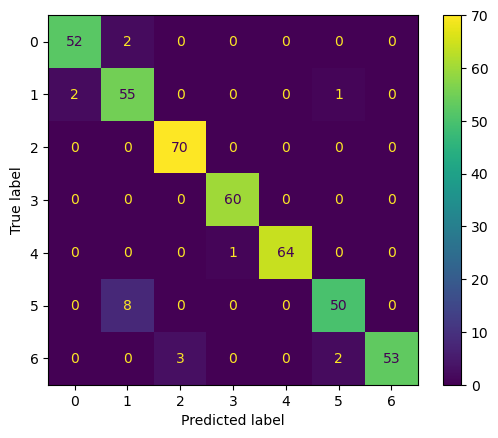

In [6]:
# Create SVC confusion matrix
cm_svc = confusion_matrix(y_test_reshaped, y_pred_svc)
ConfusionMatrixDisplay(confusion_matrix = cm_svc).plot();

In [14]:
# Define function to plot ROC curve for different models
class_names = np.unique(y_test)

# Define custom intervals for x and y axes
x_ticks = np.arange(0.0, 0.2, 0.05)
y_ticks = np.arange(0.8, 1.05, 0.05)

def plot_roc_curve(model, X_test, y_test, class_names, focus_on_top_left = True, x_ticks = None, y_ticks = None):
    """
    Function to plot ROC curves for multi-class classification problem.

    Parameters:
    model (sklearn model): Trained model (SVC and GridSearch, SVC and Optuna, SVC and Optuna and Feature Selection)
    X_test (array-like): Test features
    y_test (array-like): True labels from test set
    class_names (list): List of class labels for the classes
    focus_on_top_left (bool): Zoom into the top-left quadrant of the ROC curve (default is True)
    x_ticks (list): Custom ticks for the x-axis (optional)
    y_ticks (list): Custom ticks for the y-axis (optional)
    """
    
    # Predict probabilities from the trained model
    y_prob = model.predict_proba(X_test)

    # Bin the true labels
    y_test_bin = label_binarize(y_test, classes = class_names)
    n_classes = y_prob.shape[1]

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc_per_class = dict() 
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc_per_class[i] = auc(fpr[i], tpr[i])

    # Calculate micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc_per_class["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calculate macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc_per_class["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8, 6))

    # ROC curves for micro and macro averages
    plt.plot(fpr["micro"], tpr["micro"], label = f"Micro-average ROC curve (AUC = {roc_auc_per_class['micro']:.2f})", 
             color = "pink", linestyle = ":", linewidth = 2)
    plt.plot(fpr["macro"], tpr["macro"], label = f"Macro-average ROC curve (AUC = {roc_auc_per_class['macro']:.2f})", 
             color = "navy", linestyle = ":", linewidth = 2)

    # Assign colors for each class
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "blue", "purple"])

    # Plot each class ROC curve
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color = color, lw = 2, 
                 label = f"{class_names[i]} ROC (AUC = {roc_auc_per_class[i]:.2f})")

    # Plot diagonal line (no discrimination line)
    plt.plot([0, 1], [0, 1], "k--", lw = 1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Zoom on top-left area of plot
    if focus_on_top_left:
        plt.xlim([0.0, 0.2]) 
        plt.ylim([0.8, 1.05])

    # Provide custom ticks for the x and y axes
    if x_ticks is not None:
        plt.xticks(x_ticks)
    if y_ticks is not None:
        plt.yticks(y_ticks)
        
    # Get the name of the model class
    model_name = model.__class__.__name__  
    plt.title(f"ROC Curves for {model_name} (OvR macro & micro avg)")
    plt.legend(loc = "lower right")

    plt.show()

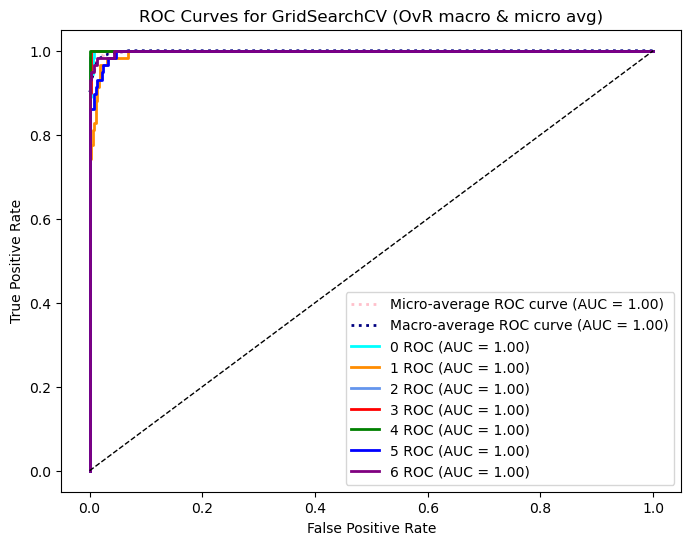

In [8]:
# Plot ROC curve for SVC and GridSearchCV model
plot_roc_curve(grid_svc, X_test, y_test, class_names, focus_on_top_left = False, x_ticks = None, y_ticks = None)

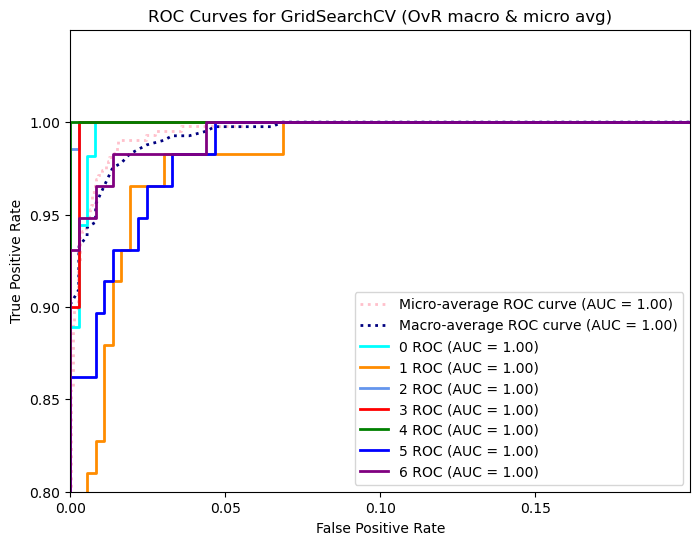

In [ ]:
# Plot zoomed-in ROC curve for SVC and GridSearchCV model
plot_roc_curve(grid_svc, X_test, y_test, class_names, focus_on_top_left = True, x_ticks = x_ticks, y_ticks = y_ticks)

### II) Compare GridSearch CV vs Optuna performance

In [11]:
# Use same svc pipeline and parameters but with optuna instead of GridSearchCV
pipe_svc = Pipeline([
    ('svc', SVC(random_state = 42, probability = True, decision_function_shape = 'ovr'))
])

# Define parameter grid search for SVC
param_grid_opt = {
    'svc__C': optuna.distributions.IntDistribution(1, 10, 50),
    'svc__kernel': optuna.distributions.CategoricalDistribution(['rbf', 'poly']),
    'svc__gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto']),
}

# OptunaSearchCV with 'accuracy' as the scoring metric
opt_svc = OptunaSearchCV(pipe_svc, param_grid_opt, n_trials = 100,
                         cv = 5, scoring = 'accuracy', n_jobs = -1,
                         verbose = 1)

opt_svc.fit(X_train, y_train_reshaped)

/var/folders/_c/rmwlj3rx6sl64n4g6ykhb47w0000gn/T/ipykernel_56858/2324702181.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_svc = OptunaSearchCV(pipe_svc, param_grid_opt, n_trials = 100,
[I 2025-07-23 23:19:39,018] A new study created in memory with name: no-name-af3fbb03-56bb-4bb2-bda0-b0e21be1dd57
[I 2025-07-23 23:19:44,315] Trial 2 finished with value: 0.9223868804101627 and parameters: {'svc__C': 2, 'svc__kernel': 'poly', 'svc__gamma': 'scale'}. Best is trial 2 with value: 0.9223868804101627.
[I 2025-07-23 23:19:44,354] Trial 3 finished with value: 0.9223868804101627 and parameters: {'svc__C': 2, 'svc__kernel': 'poly', 'svc__gamma': 'scale'}. Best is trial 2 with value: 0.9223868804101627.
[I 2025-07-23 23:19:47,284] Trial 1 finished with value: 0.9354274577283024 and parameters: {'svc__C': 9, 'svc__kernel': 'rbf', 'svc__gamma': 'auto'}. Best is trial 1 with value: 0.9354274577283024.
[I 2025-07-23 2

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('svc',
                                          SVC(probability=True,
                                              random_state=42))]),
               n_jobs=-1, n_trials=100,
               param_distributions={'svc__C': IntDistribution(high=10, log=50, low=1, step=1),
                                    'svc__gamma': CategoricalDistribution(choices=('scale', 'auto')),
                                    'svc__kernel': CategoricalDistribution(choices=('rbf', 'poly'))},
               scoring='accuracy', verbose=1)

In [12]:
# Print the best parameters and score
print(f"\nBest SVC Opt parameters: {opt_svc.best_params_}")
print(f"Best cross-validated Accuracy: {opt_svc.best_score_:.4f}")

# Evaluate the best model on the test set
y_pred_opt = opt_svc.predict(X_test)
train_acc_opt = accuracy_score(y_train_reshaped, opt_svc.predict(X_train))
test_acc_opt = accuracy_score(y_test_reshaped, y_pred_opt)

print(f"SVC Opt Train Accuracy: {train_acc_opt:.4f}")
print(f"SVC Opt Test Accuracy: {test_acc_opt:.4f}")

print("\nSVC Opt Test Set Classification Report:")
print(classification_report(y_test, y_pred_opt))


Best SVC Opt parameters: {'svc__C': 4, 'svc__kernel': 'poly', 'svc__gamma': 'auto'}
Best cross-validated Accuracy: 0.9431
SVC Opt Train Accuracy: 0.9976
SVC Opt Test Accuracy: 0.9669

SVC Opt Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       0.93      0.97      0.95        58
           2       0.96      0.97      0.96        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.96      0.90      0.93        58
           6       0.95      0.95      0.95        58

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.97      0.97      0.97       423



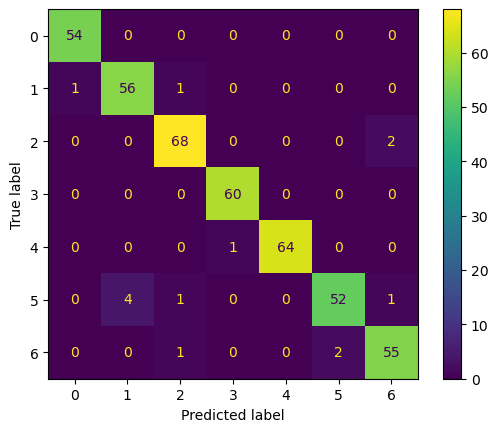

In [13]:
# Create SVC and Optuna confusion matrix
cm_svc_optuna = confusion_matrix(y_test_reshaped, y_pred_opt)

ConfusionMatrixDisplay(confusion_matrix = cm_svc_optuna).plot();

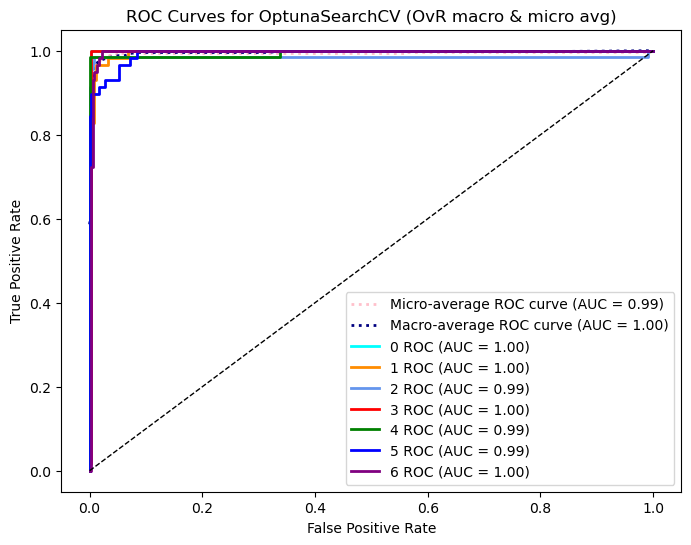

In [ ]:
# Plot ROC curve for SVC and OptunaSearchCV model
plot_roc_curve(opt_svc, X_test, y_test, class_names, focus_on_top_left = False, x_ticks = None, y_ticks = None)

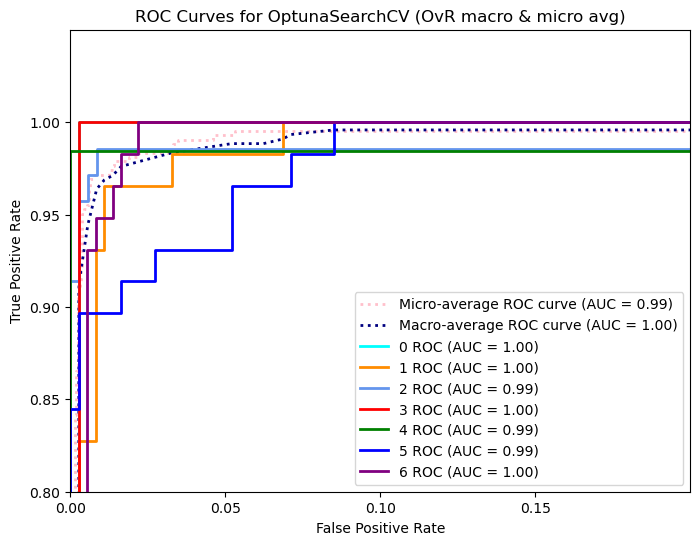

In [ ]:
# Plot zoomed-in ROC curve for SVC and OptunaSearchCV model
plot_roc_curve(opt_svc, X_test, y_test, class_names, focus_on_top_left = True, x_ticks = x_ticks, y_ticks = y_ticks)

### III) Feature Selection Using Scikit-learn mutual_info_classif

In [17]:
# Feature selection using mutual_info_classif

feat_sel = mutual_info_classif(X_train, y_train_reshaped, random_state = 42)
feat_sel_df = pd.DataFrame({
    'feature': X_train.columns,
    'mutual_info': feat_sel
}).sort_values(by = 'mutual_info', ascending = False)

display(feat_sel_df)

,feature,mutual_info
1,Weight,1.248537
0,Height,0.429016
4,FCVC,0.383194
10,FAF,0.282351
8,CH2O,0.274618
11,TUE,0.257995
5,NCP,0.238799
13,Gender_Male,0.219307
2,family_history_with_overweight,0.158614
6,CAEC,0.154062


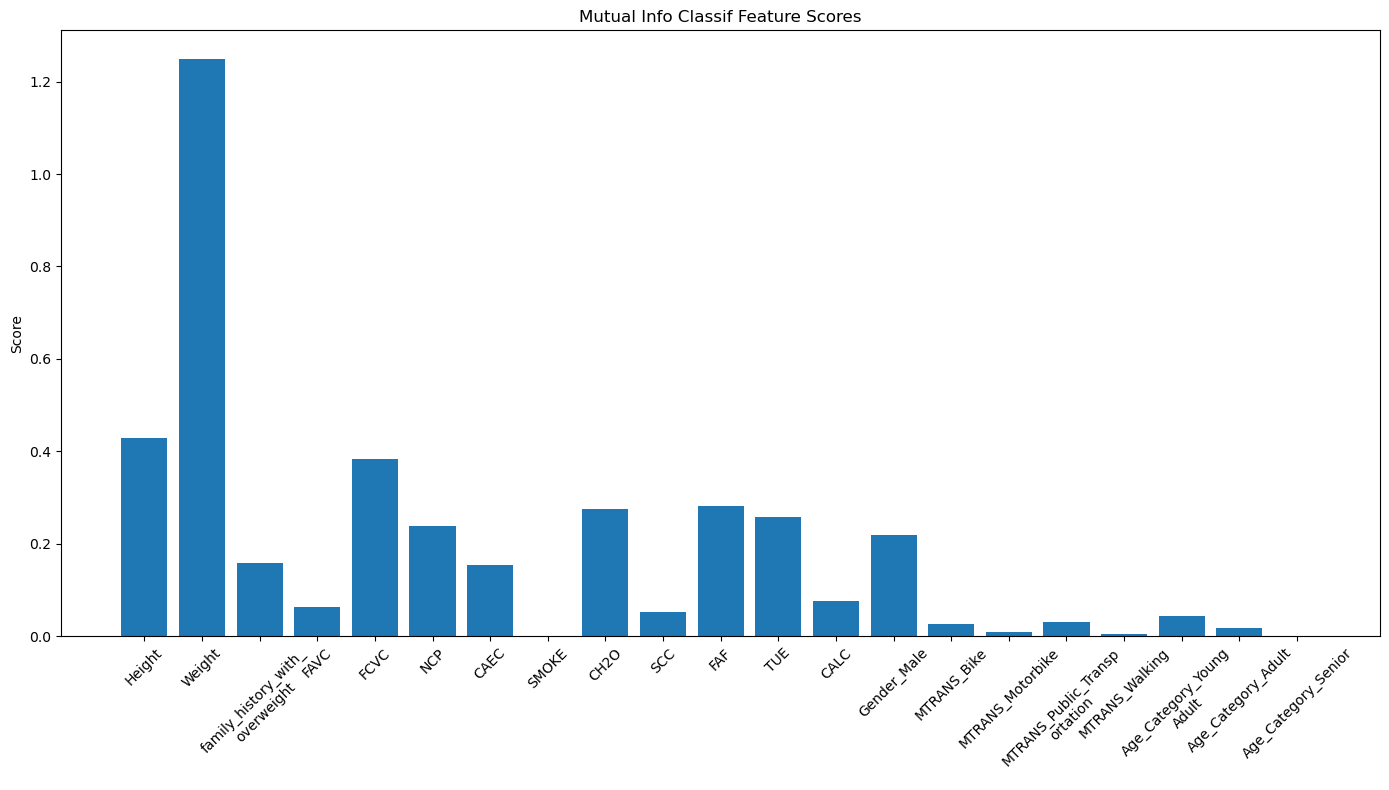

In [18]:
# Wrap long x labels
import textwrap
wrapped_labels = [textwrap.fill(label, 20) for label in X_train.columns]

plt.figure(figsize = (14, 8))
plt.bar(X_train.columns, feat_sel)
plt.xticks(ticks = range(len(wrapped_labels)),
           labels = wrapped_labels, rotation = 45)
plt.ylabel("Score")
plt.title("Mutual Info Classif Feature Scores")
plt.tight_layout()
plt.show()

In [19]:
selected_features = feat_sel_df.loc[feat_sel_df['mutual_info'] > 0.1, 'feature'].tolist()
print(selected_features)

['Weight', 'Height', 'FCVC', 'FAF', 'CH2O', 'TUE', 'NCP', 'Gender_Male', 'family_history_with_overweight', 'CAEC']


In [21]:
# Create new dataframes for selected features based on mutual info classif
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Use same svc pipeline and parameters but with optuna instead of GridSearchCV
pipe_svc = Pipeline([
    ('svc', SVC(random_state = 42, probability = True, decision_function_shape = 'ovr'))
])

# Define parameter grid search for SVC
param_grid_opt_mic = {
    'svc__C': optuna.distributions.IntDistribution(1, 10, 50),
    'svc__kernel': optuna.distributions.CategoricalDistribution(['rbf', 'poly']),
    'svc__gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto']),
}

# OptunaSearchCV with 'accuracy' as the scoring metric
opt_mic = OptunaSearchCV(pipe_svc, param_grid_opt_mic, n_trials = 100,
                         cv = 5, scoring = 'accuracy', n_jobs = -1,
                         verbose = 1)

opt_mic.fit(X_train_sel, y_train_reshaped)

/var/folders/_c/rmwlj3rx6sl64n4g6ykhb47w0000gn/T/ipykernel_56858/2091306267.py:18: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_mic = OptunaSearchCV(pipe_svc, param_grid_opt_mic, n_trials = 100,
[I 2025-07-23 23:25:55,563] A new study created in memory with name: no-name-ae8e3537-dead-4854-a62c-29bfc9f01517
[I 2025-07-23 23:26:02,220] Trial 0 finished with value: 0.9466823521149017 and parameters: {'svc__C': 3, 'svc__kernel': 'poly', 'svc__gamma': 'scale'}. Best is trial 0 with value: 0.9466823521149017.
[I 2025-07-23 23:26:02,824] Trial 2 finished with value: 0.9484662792126842 and parameters: {'svc__C': 1, 'svc__kernel': 'poly', 'svc__gamma': 'auto'}. Best is trial 2 with value: 0.9484662792126842.
[I 2025-07-23 23:26:06,855] Trial 3 finished with value: 0.8418309834424876 and parameters: {'svc__C': 1, 'svc__kernel': 'rbf', 'svc__gamma': 'scale'}. Best is trial 2 with value: 0.9484662792126842.
[I 2025-07-

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('svc',
                                          SVC(probability=True,
                                              random_state=42))]),
               n_jobs=-1, n_trials=100,
               param_distributions={'svc__C': IntDistribution(high=10, log=50, low=1, step=1),
                                    'svc__gamma': CategoricalDistribution(choices=('scale', 'auto')),
                                    'svc__kernel': CategoricalDistribution(choices=('rbf', 'poly'))},
               scoring='accuracy', verbose=1)

In [22]:
# Print the best parameters and score
print(f"\nBest SVC Opt parameters: {opt_mic.best_params_}")
print(f"Best cross-validated Accuracy: {opt_mic.best_score_:.4f}")

# Evaluate the best model on the test set
y_pred_opt_mic = opt_mic.predict(X_test_sel)
train_acc_opt_mic = accuracy_score(y_train_reshaped, opt_mic.predict(X_train_sel))
test_acc_opt_mic = accuracy_score(y_test_reshaped, y_pred_opt_mic)

print(f"Opt MIC Train Accuracy: {train_acc_opt_mic:.4f}")
print(f"Opt MIC Test Accuracy: {test_acc_opt_mic:.4f}")

print("\nOpt MIC Test Set Classification Report:")
print(classification_report(y_test, y_pred_opt_mic))


Best SVC Opt parameters: {'svc__C': 3, 'svc__kernel': 'poly', 'svc__gamma': 'auto'}
Best cross-validated Accuracy: 0.9526
Opt MIC Train Accuracy: 0.9953
Opt MIC Test Accuracy: 0.9433

Opt MIC Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.93      0.86      0.89        58
           2       0.93      0.99      0.96        70
           3       0.98      0.93      0.96        60
           4       1.00      0.98      0.99        65
           5       0.85      0.95      0.89        58
           6       0.96      0.91      0.94        58

    accuracy                           0.94       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.95      0.94      0.94       423



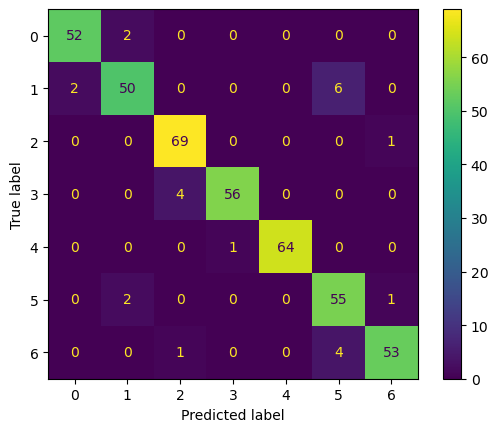

In [23]:
# Create optuna and feature selection confusion matrix
cm_opt_mic = confusion_matrix(y_test_reshaped, y_pred_opt_mic)

ConfusionMatrixDisplay(confusion_matrix = cm_opt_mic).plot();

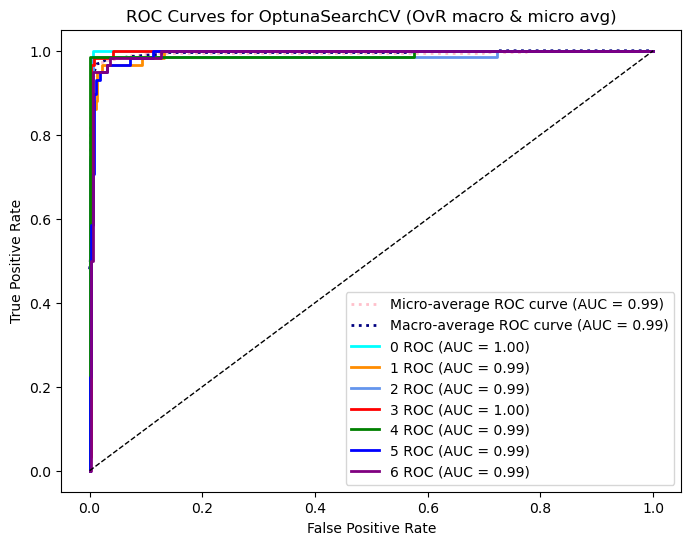

In [25]:
# Plot ROC curve for SVC, OptunaSearchCV, and multi inform classif feature selection model
plot_roc_curve(opt_mic, X_test_sel, y_test, class_names, focus_on_top_left = False, x_ticks = None, y_ticks = None)

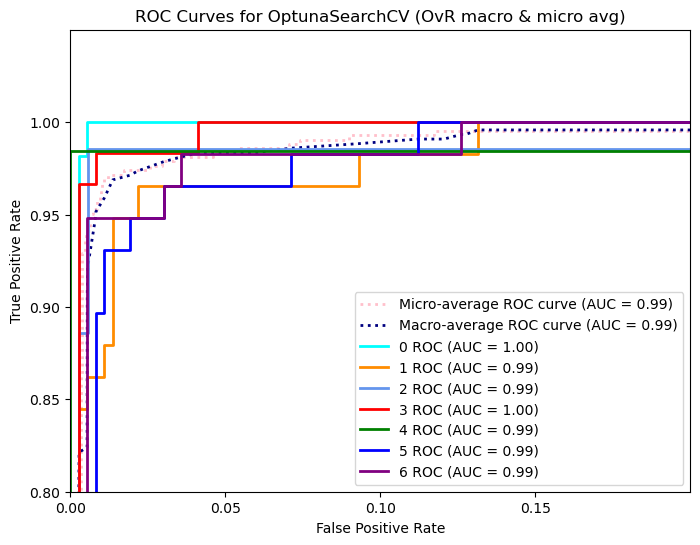

In [26]:
# Plot zoomed-in ROC curve for SVC, OptunaSearchCV, and multi inform classif feature selection model
plot_roc_curve(opt_mic, X_test_sel, y_test, class_names, focus_on_top_left = True, x_ticks = x_ticks, y_ticks = y_ticks)

### IV) Feature selection with SelectKBest

In [27]:
# Define pipeline with SelectKBest feature selection before Optuna search
pipe_opt_kbest = Pipeline([
    ('select', SelectKBest(score_func = f_classif)),  # Feature selection
    ('svc', SVC(random_state = 42, probability = True, decision_function_shape = 'ovr'))
])

# Define optuna search parameter space
params_opt_kbest = {
    'select__k': optuna.distributions.IntDistribution(6, 20, 1),
    'svc__C': optuna.distributions.IntDistribution(1, 10, 50),
    'svc__kernel': optuna.distributions.CategoricalDistribution(['rbf', 'poly']),
    'svc__gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto'])
    }

opt_kbest = OptunaSearchCV(pipe_opt_kbest, params_opt_kbest, 
                           n_trials = 100, cv = 5, n_jobs = -1, 
                           verbose = 2)
opt_kbest.fit(X_train, y_train_reshaped)

/var/folders/_c/rmwlj3rx6sl64n4g6ykhb47w0000gn/T/ipykernel_56858/1819072034.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_kbest = OptunaSearchCV(pipe_opt_kbest, params_opt_kbest,
[I 2025-07-23 23:29:41,628] A new study created in memory with name: no-name-796f0a98-0a74-4a7a-8ab2-17ce263fe92d
[I 2025-07-23 23:29:44,075] Trial 2 finished with value: 0.8993661440134849 and parameters: {'select__k': 7, 'svc__C': 3, 'svc__kernel': 'poly', 'svc__gamma': 'scale'}. Best is trial 2 with value: 0.8993661440134849.
[I 2025-07-23 23:29:44,664] Trial 1 finished with value: 0.9615068565308237 and parameters: {'select__k': 9, 'svc__C': 9, 'svc__kernel': 'poly', 'svc__gamma': 'scale'}. Best is trial 1 with value: 0.9615068565308237.
[I 2025-07-23 23:29:44,950] Trial 0 finished with value: 0.941344617491616 and parameters: {'select__k': 14, 'svc__C': 3, 'svc__kernel': 'poly', 'svc__gamma': 'scale'}. Best is trial 1 wit

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('select', SelectKBest()),
                                         ('svc',
                                          SVC(probability=True,
                                              random_state=42))]),
               n_jobs=-1, n_trials=100,
               param_distributions={'select__k': IntDistribution(high=20, log=1, low=6, step=1),
                                    'svc__C': IntDistribution(high=10, log=50, low=1, step=1),
                                    'svc__gamma': CategoricalDistribution(choices=('scale', 'auto')),
                                    'svc__kernel': CategoricalDistribution(choices=('rbf', 'poly'))},
               verbose=2)

In [28]:
# Print the best parameters and score
print(f"Best parameters for Opt KBest: {opt_kbest.best_params_}")
print(f"Best cross-validated Accuracy: {opt_kbest.best_score_:.4f}")

# Evaluate the best model on the test set
y_pred_opt_kbest = opt_kbest.predict(X_test)
train_acc_opt_kbest = accuracy_score(y_train_reshaped, opt_kbest.predict(X_train))
test_acc_opt_kbest = accuracy_score(y_test_reshaped, y_pred_opt_kbest)

print(f"\nOpt KBest Train Accuracy: {train_acc_opt_kbest:.4f}")
print(f"Opt KBest Test Accuracy: {test_acc_opt_kbest:.4f}")

print("\nOpt KBest Test Set Classification Report:")
print(classification_report(y_test, y_pred_opt_kbest))

Best parameters for Opt KBest: {'select__k': 8, 'svc__C': 6, 'svc__kernel': 'poly', 'svc__gamma': 'scale'}
Best cross-validated Accuracy: 0.9680

Opt KBest Train Accuracy: 0.9828
Opt KBest Test Accuracy: 0.9622

Opt KBest Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       0.98      0.90      0.94        58
           2       0.97      0.99      0.98        70
           3       0.98      0.97      0.97        60
           4       1.00      0.98      0.99        65
           5       0.93      0.91      0.92        58
           6       0.92      0.98      0.95        58

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423



In [29]:
# Determine which features were selected using SelectKBest
sel = opt_kbest.best_estimator_.named_steps['select']  
mask = sel.get_support()
kbest_feats = X_train.columns[mask]
print("Selected features:", list(kbest_feats))

kbest = opt_kbest.best_estimator_.named_steps['select']
kbest_mask = kbest.get_support()  # Boolean mask
kbest_indices = kbest.get_support(indices=True)  # Feature indices

# 3. Get feature scores and p-values
feature_scores = kbest.scores_
p_values = kbest.pvalues_

# 4. Show selected feature scores
print("Selected feature indices:", kbest_indices)
print("Feature scores:", feature_scores[kbest_indices])
print("P-values:", p_values[kbest_indices])

Selected features: ['Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'CALC', 'Gender_Male']
Selected feature indices: [ 0  1  2  3  4  6 12 13]
Feature scores: [  29.14817048 1559.94140275  112.85057837   36.21370602   87.34353187
   65.60686093   28.31783003  127.86060647]
P-values: [2.39684517e-033 0.00000000e+000 8.29702561e-120 2.00599740e-041
 1.77597950e-095 2.03890040e-073 2.17957035e-032 2.05693900e-133]


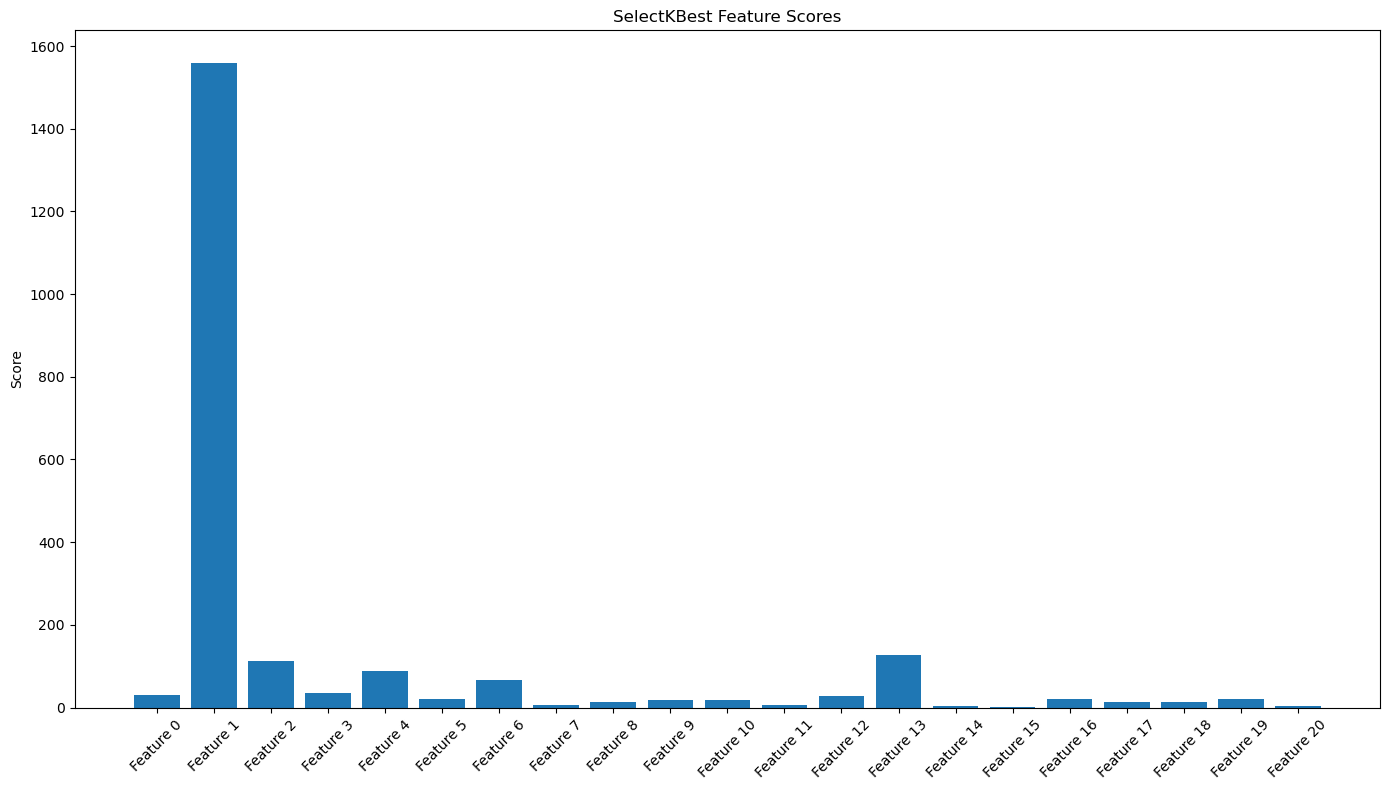

In [30]:
# Show features and score by SelectKBest 
feature_names = [f"Feature {i}" for i in range(len(feature_scores))]

# Convert to array if needed
feature_scores = np.array(feature_scores)

plt.figure(figsize = (14, 8))
plt.bar(feature_names, feature_scores)
plt.xticks(rotation = 45)
plt.ylabel("Score")
plt.title("SelectKBest Feature Scores")
plt.tight_layout()
plt.show()

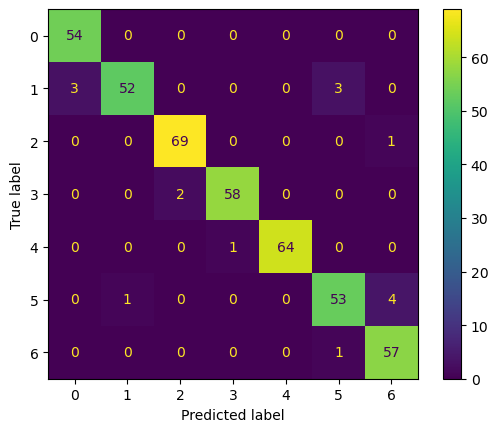

In [31]:
# Create Optuna and KBestconfusion matrix
cm_opt_kbest = confusion_matrix(y_test_reshaped, y_pred_opt_kbest)

ConfusionMatrixDisplay(confusion_matrix = cm_opt_kbest).plot();

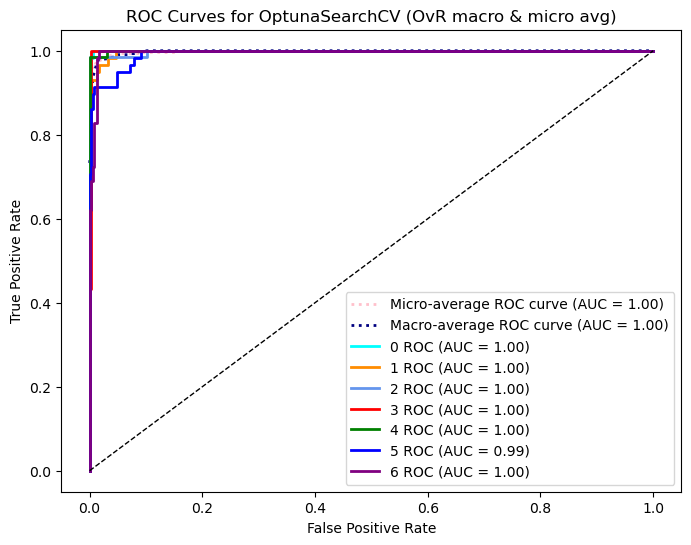

In [32]:
# Plot ROC curve for SVC, OptunaSearchCV, and select KBest feature selection model
plot_roc_curve(opt_kbest, X_test, y_test, class_names, focus_on_top_left = False, x_ticks = None, y_ticks = None)

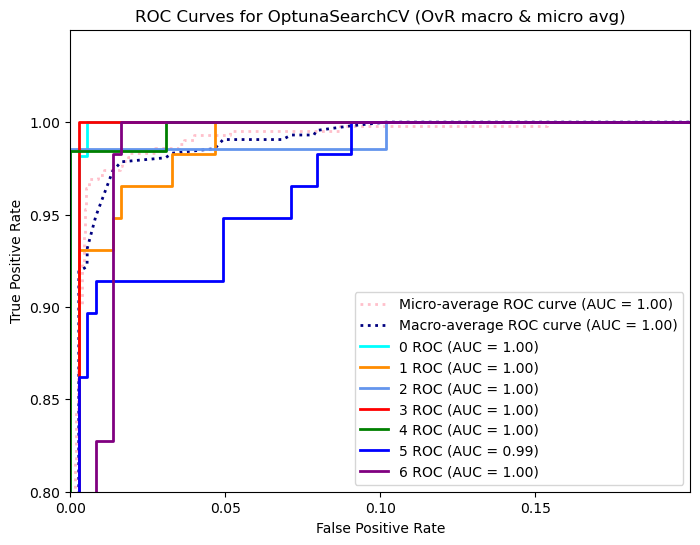

In [33]:
# Plot zoomed-in ROC curve for SVC, OptunaSearchCV, and select KBest feature selection model
plot_roc_curve(opt_kbest, X_test, y_test, class_names, focus_on_top_left = True, x_ticks = x_ticks, y_ticks = y_ticks)